# Sweet Lift Taxi Co

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Project Instructions**

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

**Data Description**

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

</div>

## Libraries & Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

## Preparation

In [9]:
# Importing data and resampling by 1 hour

df = pd.read_csv('taxi.csv')

# Viewing overview of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


<div style="border: 2px solid black; padding: 10px; margin: 20px">

After viewing `info()`, we see that the `datetime` column is not in the correct dtype. We will convert the `datetime` column and then resample by 1 hour.

</div>

### Data Types

In [14]:
# Renaming 'datetime' column to 'time_stamp', then converting
df = df.rename(columns={'datetime': 'time_stamp'})

# Converting newly name 'time_stamp' column to datetime format
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# Making the 'time_stamp' column the index & sorting
df = df.set_index('time_stamp').sort_index()

In [15]:
# Validating changes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<div style="border: 2px solid black; padding: 10px; margin: 20px">

We can see now the index was converted successfully to 'DatetimeIndex'.<br>
We can now resample the data.

</div>

### Resampling

/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_84882/2510324900.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


<Axes: xlabel='time_stamp'>

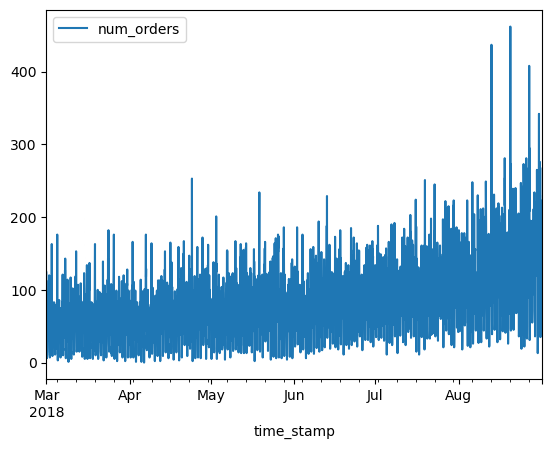

In [20]:
# Resampling by 1 hour
df = df.resample('1H').sum()

# Plotting resampled data
df.plot()

### Duplicates

In [24]:
# Searching for duplicate values
df.duplicated().sum()

4165

In [25]:
# Displaying where the duplicates are in the data
duplicate_summary = pd.DataFrame({
    "duplicates_count": [df[col].duplicated().sum() for col in df.columns],
    "duplicates_percent": [df[col].duplicated().mean() * 100 for col in df.columns],
    "unique_valuesa": [df[col].nunique() for col in df.columns],
    "total_rows": len(df)
}, index=df.columns)

duplicate_summary

,duplicates_count,duplicates_percent,unique_valuesa,total_rows
num_orders,4165,94.316123,251,4416


<div style="border: 2px solid black; padding: 10px; margin: 20px">

Although we see the majority of the values in this column duplicated, it is probable that the value it's measuring could have the same result many times. We will not remove or modify the duplicates in the dataframe to preserve the information for training.

</div>

### Missing Values

In [30]:
# Searching for missing values
df.isna().sum()

num_orders    0
dtype: int64

<div style="border: 2px solid black; padding: 10px; margin: 20px">

No missing values!

</div>

## Analysis

<div style="border: 2px solid black; padding: 10px; margin: 20px">

After plotting our data that was resampled by 1 hour intervals, we see there is a lot of data plotted. We will apply a <b>rolling mean</b> to help clarify the visualization of the data.

</div>

### Rolling Mean

<Axes: xlabel='time_stamp'>

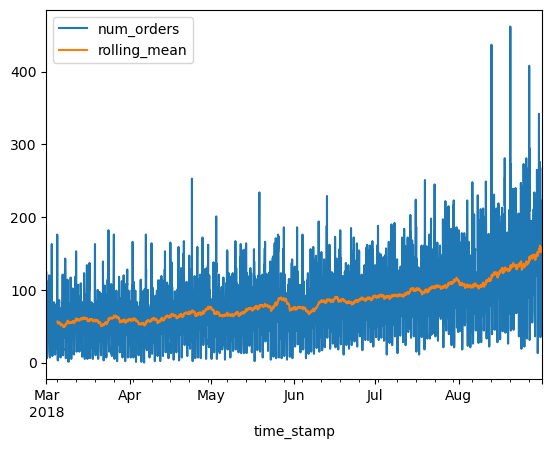

In [37]:
# Inputting rolling mean into the data

df['rolling_mean'] = df.rolling(100).mean()

df.plot()

<div style="border: 2px solid black; padding: 10px; margin: 20px">

In our <b>rolling mean</b> graph above, we see there is an overall positive direction over the months from <u>March</u> to <u>August</u>, which some fluctuations throughout.
<br>

We will continue our analysis finding trends and/or seasonality that may be present within the data.

</div>

### Trends & Seasonality

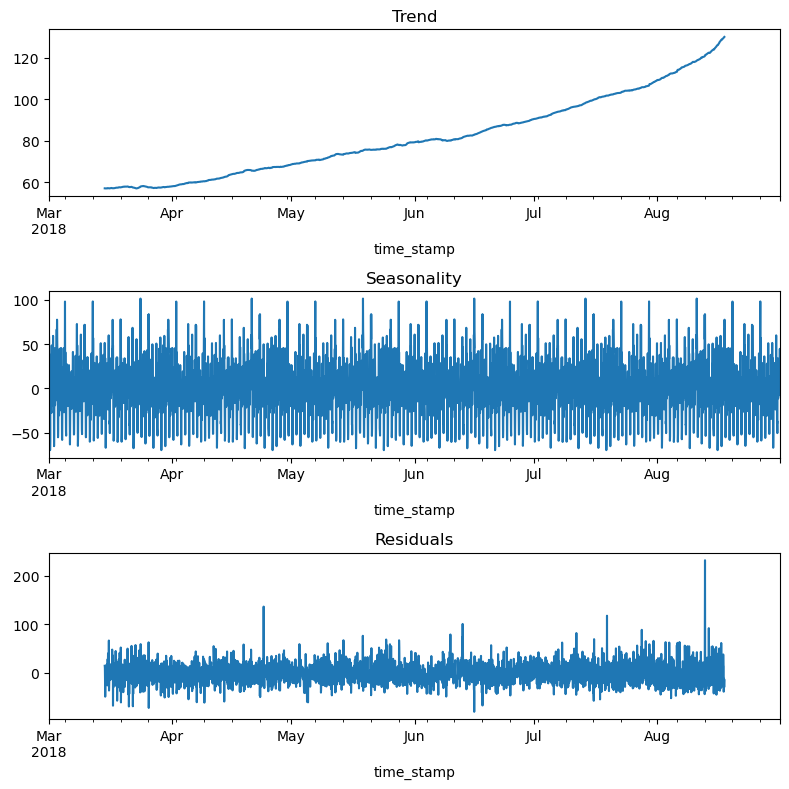

In [42]:
# Removing rolling mean column for clarity
df = df['num_orders']

# First we will detect any seasonality within the df
# Setting weekly seasonality (period=672)
decomposed = seasonal_decompose(df, period=672)

# Plotting the resulting decomposed tables
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<div style="border: 2px solid black; padding: 10px; margin: 20px">

Here's what we're seeing:
* <b>Trend</b>:<br>
We're seeing growth here from around 10 orders daily to about over 20 orders daily. This is a positive trend and is showing consistent growth over several months.

* <b>Seasonality</b>:<br>
Here, the pattern oscillates between roughly <b>-10 and +10</b> in every period. It's very tight and repetitive because of the rate of decomposition chosen.

* <b>Residuals</b>:<br>
This graph should show a relatively consistent range of data throughout the entire timeframe. We're seeing some spikes towrads the end of May, in the middle of June, and in July and August as well. These represent outliers in the data.
<br>

For further analysis, before training our models, we'll fun an `ADFuller` test to determine which model is most appropriate for our data.

</div>

## Training

### Testing Stationarity

In [48]:
# We'll begin by separating the data into training and test sets
train, test = train_test_split(df, shuffle=False, test_size=0.10)

# Running the ADFuller test to determine best fit for first model
df_stationarity = adfuller(train, autolag='AIC')

print("P-Value:", df_stationarity[1])

P-Value: 0.0007322730527364245


<div style="border: 2px solid black; padding: 10px; margin: 20px">

Our result, <b>0.000732</b>, is less than 0.05 meaning the series is very likely <b>stationary</b>.
<br>

Because our data is stationary, we can use the <b>ARMA</b> Model to find greater accuracy results. We will attempt to train an <b>Autoregression Model</b>, a <b>Moving Average Model</b>, and lastly an <b>ARMA Model</b>.
<br>

We'll conclude with an <b>Auto ARIMA Model</b> to detect if another model produces better rMSE scoring.

</div>

### Autoregression

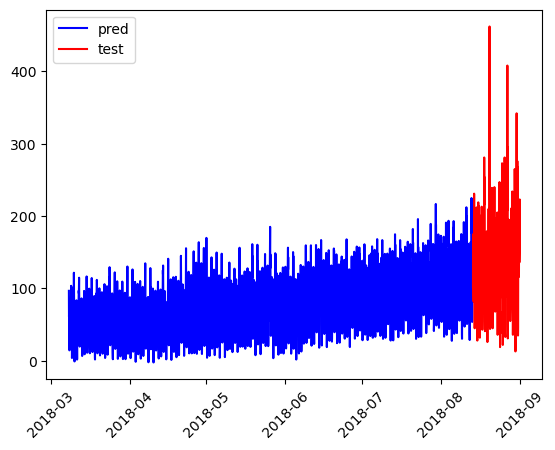


AutoRegression rMSE: 20.12


In [53]:
# First, finding the optimal number of lags
mod = ar_select_order(endog=train, maxlag=200)
ar_order = mod.ar_lags

# Creating AR Model and fitting with training set
ar_model = AutoReg(train, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

# Making predictions
start_value = 0
end_value = len(train) - 1
ar_train_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# Dropping NaNs when comparing to true values
aligned = pd.concat([train, ar_train_pred], axis=1).dropna()
y_true, y_hat = aligned.iloc[:, 0], aligned.iloc[:, 1]

# Plotting results
plt.plot(ar_train_pred, color='blue', label='pred')
plt.plot(test, color='red', label='test')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

# Calculating MAE
ar_rmse = np.sqrt(mean_squared_error(y_true,  y_hat))
print()
print(f"AutoRegression rMSE: {ar_rmse:.2f}")

### Moving Average

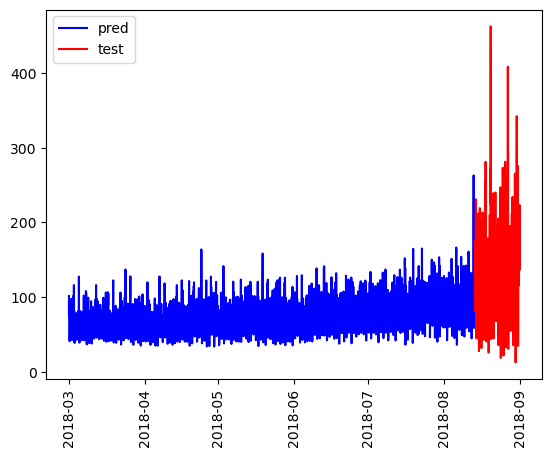


Moving Average rMSE: 32.01


In [57]:
# Finding optimal order for MA model
res = arma_order_select_ic(y=train, max_ar=0, max_ma=3)
ma_order = res.bic_min_order[1]

# Creating and fitting an MA model
ma_model = ARIMA(train, order=(0, 0, ma_order))
ma_model = ma_model.fit()

# Making predictions on MA model
ma_train_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

# Plotting results
plt.plot(ma_train_pred, color="blue", label="pred")
plt.plot(test, color="red", label="test")
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

# Calculating MAE
ma_train_rmse = np.sqrt(mean_squared_error(train, ma_train_pred))
print()
print(f"Moving Average rMSE: {ma_train_rmse:.2f}")

### ARMA

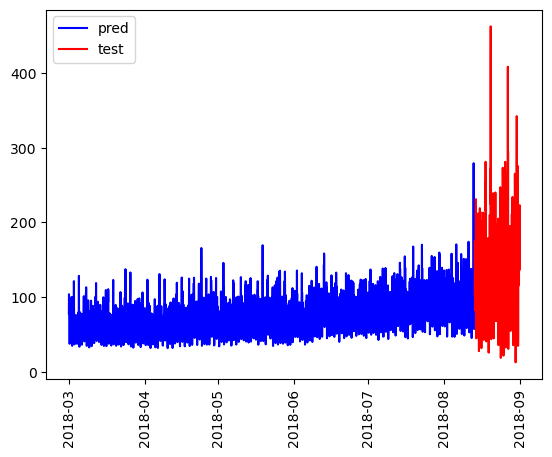


ARMA Model rMSE: 31.79


In [61]:
# Training the ARMA model
arma_model = ARIMA(train, order=(1, 0, 1))
arma_model = arma_model.fit()

# Predicting on the ARMA model
arma_train_pred = arma_model.predict(start=start_value, end=end_value, dynamic=False)

# Plotting results
plt.plot(arma_train_pred, color="blue", label="pred")
plt.plot(test, color="red", label="test")
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.show()

# Calculating MAE
arma_train_rmse = np.sqrt(mean_squared_error(train, arma_train_pred))
print()
print(f"ARMA Model rMSE: {arma_train_rmse:.2f}")

### AutoARIMA

In [65]:
# Creating an AutoARIMA model
aa_model = auto_arima(train,
                      seasonal=True,
                      m=24, # weekly seasonality
                      start_p=0, max_p=1, 
                      start_q=0, max_q=1,
                      start_P=0, max_P=0,
                      start_Q=0, max_Q=0,
                      max_order=3,
                      d=1, D=0,
                      stepwise=True,
                      suppress_warnings=True,
                      trace=True
)

# Predictions on the training model first
aa_train_pred = aa_model.predict_in_sample()

# Calculating rMSE
aa_train_rmse = np.sqrt(mean_squared_error(train, aa_train_pred))

print("AutoARIMA Training rMSE:", aa_train_rmse)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=39785.522, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=39407.923, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=39248.315, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=39783.522, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=39246.314, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[24]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[24]             : AIC=39405.923, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[24]          
Total fit time: 1.100 seconds
AutoARIMA Training rMSE: 33.82692758887935


<div style="border: 2px solid black; padding: 10px; margin: 20px">

A lot of parameter tuning needed to be done to be able to manage computational demand in the kernel. "m=24" parameter was set to denote a daily seasonality (since we resampled our data into hours). Below, we will extract the information for the model that AutoARIMA chose as the best for the data provided.

</div>

#### Model & Params

In [68]:
# Extracting the model and parameters that AutoARIMA chose

parameters = aa_model.get_params()

for key, value in parameters.items():
    print(f"{key}: {value}")

maxiter: 50
method: lbfgs
order: (0, 1, 1)
out_of_sample_size: 0
scoring: mse
scoring_args: {}
seasonal_order: (0, 0, 0, 24)
start_params: None
suppress_warnings: True
trend: None
with_intercept: False


### Final rMSE's

In [72]:
# Final rMSE's for each model on Training Set

print(f"AutoRegression rMSE: {ar_rmse:.2f}")
print(f"Moving Average rMSE: {ma_train_rmse:.2f}")
print(f"ARMA Model rMSE: {arma_train_rmse:.2f}")
print(f"AutoARIMA Model rMSE: {aa_train_rmse:.2f}")

AutoRegression rMSE: 20.12
Moving Average rMSE: 32.01
ARMA Model rMSE: 31.79
AutoARIMA Model rMSE: 33.83


<div style="border: 2px solid black; padding: 10px; margin: 20px">

It's clear that our <b>AutoRegression Model</b> had the lowest rMSE score compared to the <u>Moving Average</u> and more complex <u>ARMA</u> models, as well as the <u>AutoARIMA Model</u>. 
<br>

We will use this model to predict on the test data for the final test.

</div>

## Testing & Final Observations

### AR Model on Test Data

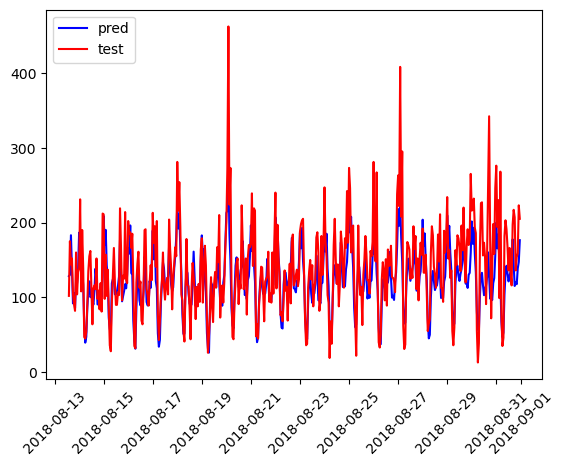


AutoRegression rMSE: 40.47


In [78]:
# Making predictions
start_value_final = len(train)
end_value_final = len(train) + len(test) - 1
ar_pred_final = ar_model.predict(start=start_value_final, 
                                 end=end_value_final, 
                                 dynamic=False)

# Plotting results
plt.plot(ar_pred_final, color='blue', label='pred')
plt.plot(test, color='red', label='test')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

# Calculating MAE
ar_rmse_final = np.sqrt(mean_squared_error(test,  ar_pred_final))
print()
print(f"AutoRegression rMSE: {ar_rmse_final:.2f}")

<div style="border: 2px solid black; padding: 10px; margin: 20px">

The AR Model used on the **test data** produced a **<u>lower</u>** rMSE score than it did in the iteration predicting on the **training data**.
<br>

This shows a successful model with the AutoRegression Model in determining how many rides there would be in the next hour for the Sweet Lift Taxi Co.

</div>